# GRADCAM

Let's start with a pretrained VGG model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [2]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0717 15:45:53.438344 140291882604416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 15:45:53.474932 140291882604416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 15:45:53.481745 140291882604416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 15:45:53.520842 140291882604416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0717 15:46:00.536698 140291882604416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 15:46:00.538268 140291882604416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
import cv2
import keras.backend as K

def gradCAM(model, img, img_arr, layer_name):
    # img_arr is preprocess form of img
    x = img_arr
    
    # We get the predictions for the image
    preds = model.predict(x)
    
    # We take the topmost class index
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    
    # Take output from the final convolutional layer
    last_conv_layer = model.get_layer(layer_name)
   
    # Compute the gradient of the class output value with respect to the feature map
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    
    # Pool the gradients over all the axies leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Iterate through all channels and merge them
    # Weigh the output feature map with the computed gradient values
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(last_conv_layer.kernel.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Average the feature maps along channel dimension resulting in
    # heatmp of size same as kernel size of layer in consideration
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    
    # Normalize the heat map to make the values between 0 and 1
    heatmap /= np.max(heatmap)

    # Resize heatmap to match image shape
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Generate heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose heatmap onto image
    superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    return superimposed_img

### Build GradCAM images for last three layers

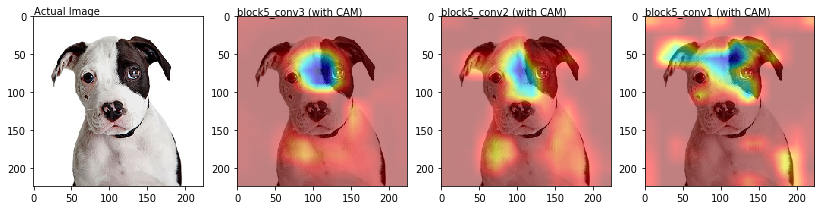

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

# Layers of which CAM is required
conv_layers = ["block5_conv3", "block5_conv2", "block5_conv1"]
# Number of images to be used in visualization
num_images = 1


fig=plt.figure(figsize=(14, 14))
columns = 1 + len(conv_layers)
rows = num_images

placeHolderId = 0
while placeHolderId < rows*columns:
    # Original Image
    placeHolderId += 1
    fig.add_subplot(rows, columns, placeHolderId)
    plt.imshow(dog)
    annotation = "Actual Image"
    plt.annotate(annotation, xy=(0,0), xytext=(0,-2.5), fontsize=10)
    
    for layer_name in conv_layers:
      # gradCAM Imposed Image
      placeHolderId += 1
      superimposed_img = gradCAM(model, dog, x, layer_name)
      fig.add_subplot(rows, columns, placeHolderId)
      plt.imshow(superimposed_img)
      annotation = layer_name + " (with CAM)"
      plt.annotate(annotation, xy=(0,0), xytext=(0,-2.5), fontsize=10)

plt.show()

### Find  "sunglasses" in the image using GradCAM

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
tony = io.imread("https://i.ibb.co/d40tvMN/16-scale-tony-stark-avenger3-headscrupt-with-glasses-1534759826-e79b0cf4.jpg")
tony = cv2.resize(tony, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tony)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#### Class ID predicted is of Sunglasses. It can be verified from below link
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

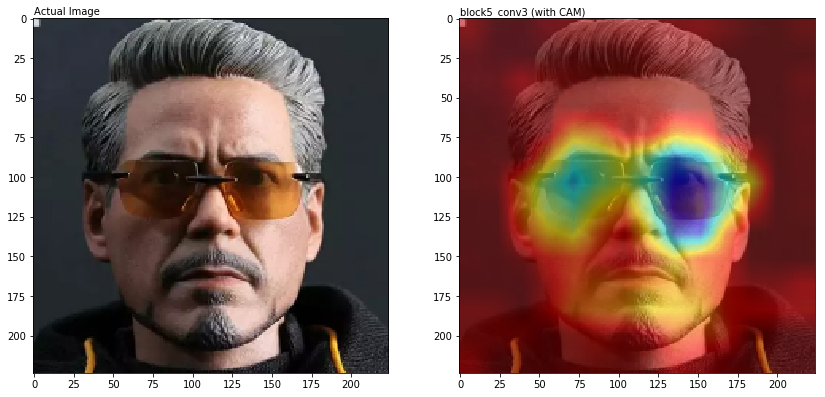

In [36]:
from matplotlib import pyplot as plt
%matplotlib inline

# Layers of which CAM is required
conv_layers = ["block5_conv3"]
# Number of images to be used in visualization
num_images = 1


fig=plt.figure(figsize=(14, 14))
columns = 1 + len(conv_layers)
rows = num_images

placeHolderId = 0
while placeHolderId < rows*columns:
    # Original Image
    placeHolderId += 1
    fig.add_subplot(rows, columns, placeHolderId)
    plt.imshow(tony)
    annotation = "Actual Image"
    plt.annotate(annotation, xy=(0,0), xytext=(0,-2.5), fontsize=10)
    
    for layer_name in conv_layers:
      # gradCAM Imposed Image
      placeHolderId += 1
      superimposed_img = gradCAM(model, tony, x, layer_name)
      fig.add_subplot(rows, columns, placeHolderId)
      plt.imshow(superimposed_img)
      annotation = layer_name + " (with CAM)"
      plt.annotate(annotation, xy=(0,0), xytext=(0,-2.5), fontsize=10)

plt.show()

### Calculating Receptive Field from Research Paper